# In the Name of God

mohammad mohajel sadegi - 810199483

# Imports:

In [1]:
import math
import pandas as pd
import numpy as np
import hazm
import matplotlib.pyplot as plt
import itertools

# Defines:

In [2]:
TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
IGNORE_CASES = ["گزارش", "ایسنا"]
MIN_FREQ_IN_TRAIN_DATA = 1
BIGRAM_WEIGHT = 5
INITIAL_SCORE = 2000
ADDITIVE_SMOOTHING = True

# Lemmatization vs Stemming:

In [3]:
stemmer = hazm.Stemmer()
print(stemmer.stem("می‌رفتم"))
lemmatizer = hazm.Lemmatizer()
print(lemmatizer.lemmatize("می‌رفتم").split("#")[0])

می‌رف
رفت


# Phase 1:

In [4]:
test_data = pd.read_csv("test.csv")

In [5]:
class Parser:
    def __init__(self) -> None:
        self.normalizer = hazm.Normalizer()
        self.lemmatizer = hazm.Lemmatizer()
        self.tokenize = hazm.word_tokenize
        self.stop_words = hazm.stopwords_list()
        self.stop_words = self.stop_words + IGNORE_CASES

    def parse(self, text : str):
        tokens = self.tokenize(self.normalizer.normalize(text))
        tokens = [elem for elem in tokens if elem not in self.stop_words and elem.isalpha()]
        tokens = [self.lemmatize(elem) for elem in tokens if elem not in self.stop_words]
        return tokens

    def unigram_parse(self, text : str):
        tokens = self.parse(text)
        return tokens    

    def bigram_parse(self, text : str):
        tokens = self.parse(text)
        bigram_tokens = []
        for i in range(len(tokens) - 1):
            bigram_tokens.append(tokens[i] + " " + tokens[i + 1])
        return bigram_tokens

    def lemmatize(self, word :str) -> str:
        return self.lemmatizer.lemmatize(word).split('#')[0]

In [6]:
class Topic:
    def __init__(self, name) -> None:
        self.name = name
        self.words = {}
        self.N = 0
        self.sorted = False

    def sort_words(self):
        if self.sorted:
            return
        self.words = {k: v for k, v in sorted(self.words.items(), key=lambda item: item[1],\
                      reverse=True) if v >= MIN_FREQ_IN_TRAIN_DATA}
        for count in self.words.values():
            self.N += count
        self.sorted = True
    
    def add(self, tokens, alpha = 1):
        for t in tokens:
            if t in self.words:
                self.words[t] += alpha
            else:
                self.words.update({t: alpha})

    def plot(self, n :int):
        self.sort_words()
        result = dict(itertools.islice(self.words.items(), n))
        plt.bar(result.keys(), result.values())
        plt.xlabel(self.name)
        plt.ylabel('frequency')
        plt.show()    

    def cal_score(self, content):
        self.sort_words()
        score = INITIAL_SCORE
        minimum_score = 0
        if ADDITIVE_SMOOTHING:
            minimum_score = math.log2(1/ self.N)
        else:
            minimum_score = -math.inf
        for w in content:
            if w in self.words:
                score += math.log2(self.words[w]/ self.N)
            else:
                score += minimum_score
        return score

In [7]:
topics = {}
p = Parser()
def train(TRAIN_FILE):
    train_data = pd.read_csv(TRAIN_FILE)
    for _, row in train_data.iterrows():
        label = row["label"]
        text = row["content"]
        unigram_content = p.unigram_parse(text)
        bigram_content = p.bigram_parse(text)

        if label not in topics:
            topics.update({label: Topic(label)})

        topics[label].add(unigram_content)    
        topics[label].add(bigram_content, BIGRAM_WEIGHT)    

In [8]:
train(TRAIN_FILE)

# Phase 2:

In [9]:
def predict_category(content):
    max_score = -math.inf
    chosen_topic = ""
    for t in topics:
        if(topics[t].cal_score(content) > max_score):
            max_score = topics[t].cal_score(content)
            chosen_topic = t
    return chosen_topic

In [10]:
def predict():
    pred = []
    for index, row in test_data.iterrows():
        label = row["label"]
        text = row["content"]
        unigram_content = p.unigram_parse(text)
        bigram_content = p.bigram_parse(text)
        predicted_label = predict_category(unigram_content + bigram_content)
        pred.append(predicted_label)
    return pred

In [11]:
pred = predict()

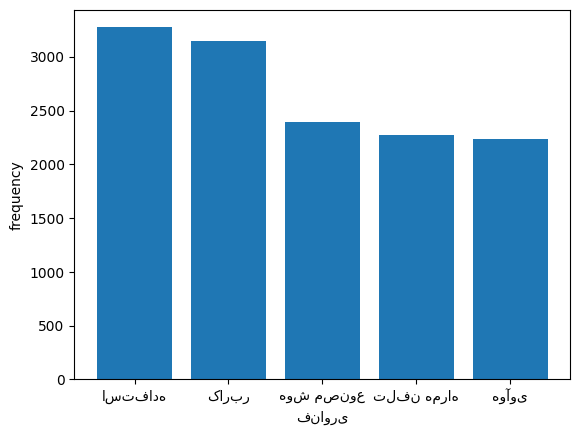

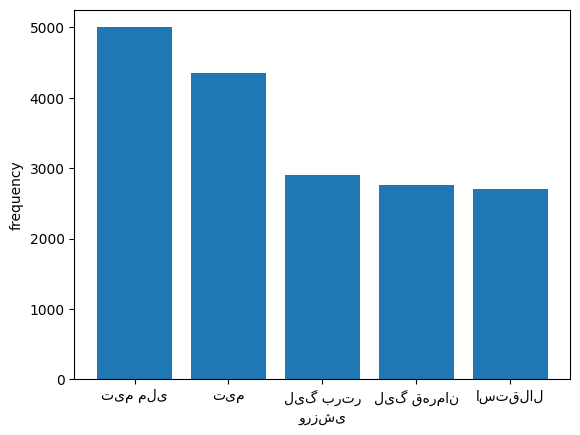

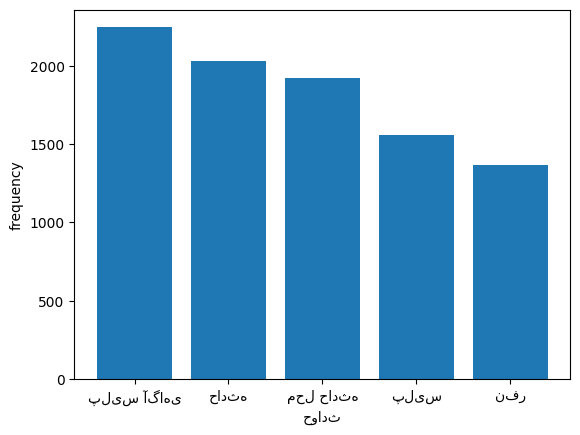

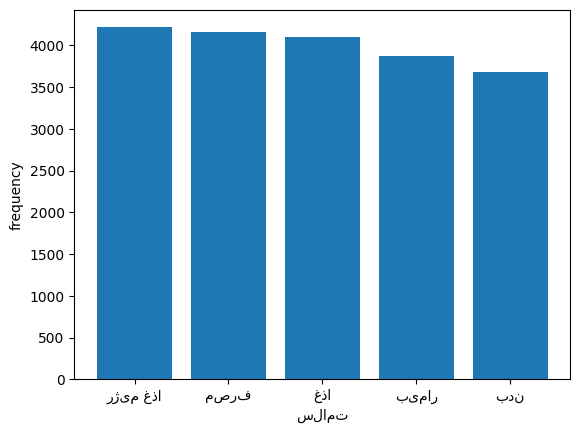

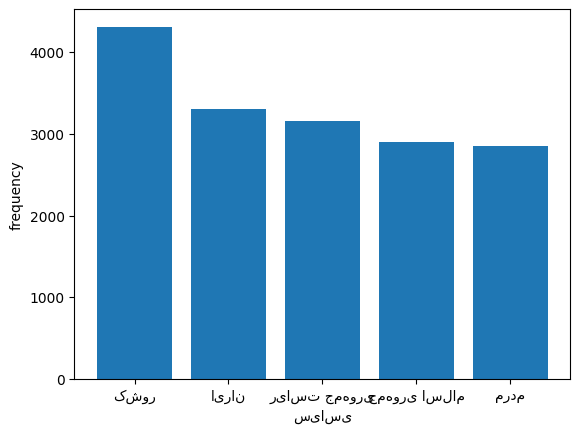

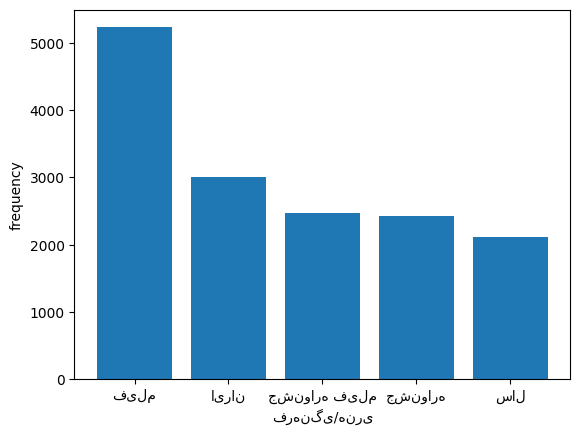

In [12]:
for topic in topics.values():
    topic.plot(5)

# Phase 3:

In [13]:
def print_assessments(name :str) -> None:
    correct_detected = 0
    all_detected = 0
    totall = 0
    for i in range(len(pred)):
        if pred[i] == name:
            all_detected += 1
        if test_data["label"][i] == name:
            totall += 1
        if pred[i] == name and pred[i] == test_data["label"][i]:
            correct_detected += 1

    persision = correct_detected / totall
    recall = correct_detected / all_detected
    f1 = 2 * (persision * recall) / (persision + recall)
    print(f"Topic:{name}")
    print(f"totall:{totall}")
    print(f"persision = {persision}")
    print(f"recall = {recall}")
    print(f"F1 = {f1}")
    print("**********************************")

In [14]:
for name in topics:
    print_assessments(name)

Topic:فناوری
totall:168
persision = 0.9642857142857143
recall = 0.9642857142857143
F1 = 0.9642857142857143
**********************************
Topic:ورزشی
totall:190
persision = 0.9736842105263158
recall = 0.9840425531914894
F1 = 0.9788359788359788
**********************************
Topic:حوادث
totall:200
persision = 0.985
recall = 0.8834080717488789
F1 = 0.9314420803782506
**********************************
Topic:سلامت
totall:177
persision = 0.9548022598870056
recall = 0.976878612716763
F1 = 0.9657142857142856
**********************************
Topic:سیاسی
totall:200
persision = 0.925
recall = 0.9203980099502488
F1 = 0.9226932668329176
**********************************
Topic:فرهنگی/هنری
totall:180
persision = 0.8722222222222222
recall = 0.9691358024691358
F1 = 0.9181286549707603
**********************************


In [16]:
WRONG_PREDICION_SHOW_COUNT = 5
wrong_predict = 0
for i in range(len(pred)):
    if wrong_predict == WRONG_PREDICION_SHOW_COUNT:
        break
    if pred[i] != test_data['label'][i]:
        print(f"predict:{pred[i]},,trueRes:{test_data['label'][i]},, newsLine:{i}")
        print(f"content:\n{test_data['content'][i]}\n")
        wrong_predict += 1

predict:سیاسی,,trueRes:فرهنگی/هنری,, newsLine:30
content:
- چهارشنبه اول تیر 1401 اتفاق نادر و جالبی رخ داد که قطعا به صورت تصادفی و بدون برنامه‌ریزی و اطلاع قبلی بوده است: این که به شکل کاملا هم‌زمان در محل انجمن صنفی روزنامه‌نگاران استان تهران از رونمایی شد و در صدا‌و‌سیما و در جمع معاونان سازمان هم از کلیات « ».   اگرچه سه واژۀ در هر دو مشترک‌اند اما هیچ ربط و شباهتی به هم ندارند. چرا که در اولی منظور از سند است و در دومی سند (در حالی که به تعبیر دکتر وب‌2 را هم پشت سر گذاشته و به زودی وارد وب‌3 خواهیم شد) و خود رادیو و تلویزیون دیگر رسانۀ مدرن نیست و به تعبیری رسانۀ تلویزیون در معنی عام و جهانی نه مشخصا صدا و سیما هر چند در ایران همچنان رایگان‌ترین و گسترده‌ترین امکان وقت‌گذرانی و ارتباطی است. (رایگان از جهت پرداخت حق اشتراک وگرنه بودجۀ آن از جیب ملت تأمین می‌شود). در اولی منظور از رسانه واقعا رسانه است. یعنی بدون بودجۀ حکومتی و مخاطب‌محور و در دومی به جز تعبیر «رسانه ملی» در باقی موارد ترجیح می‌دهند از مفاهیم ایدیولوژیک استفاده کنند و آن را در واقع عرصۀ جنگ می‌دانند یا با واژه های